In [225]:
import os
import site
from pathlib import Path
import importlib  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

path = Path(os.getcwd())
site.addsitedir(path.parent)  

dataset_cleaning = importlib.import_module("utils.dataset_cleaning")

# the datasets that are returned are cleaned
df_aircraft = dataset_cleaning.clean_aircraft(
    '../../Resources/ACchar.xlsx', 
    )

df_airport = dataset_cleaning.clean_airport(
    '../../Resources/training_set_airport_data.csv', 'train'
    )

df_geography = dataset_cleaning.clean_geography(
    '../../Resources/geographic_data.csv', 
    )

df_weather = dataset_cleaning.clean_weather(
    '../../Resources/Weather_data.csv', 'train'
    )

dataset_joining = importlib.import_module("utils.dataset_joining")

# joining cleaned datasets and combining them
# you do not have to list all datasets if you only want to join some of them
# but df_airport is the only one mandatory
merged_df = dataset_joining.join_datasets(df_airport, df_weather=df_weather,df_geography=df_geography, df_aircraft=df_aircraft)
merged_bkp = merged_df.copy()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning:

Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.



### Adding distance between stand and runway

In [226]:
pairs = pd.read_csv('../../Resources/new_pairs.csv')
pairs.columns = ['index','stand','runway','distance']
merged_df = pd.merge(merged_df, pairs,  how='left', left_on=['stand','runway'], right_on = ['stand','runway'])

### Adding target variable

In [227]:
merged_df.iloc[:,2] = pd.to_datetime(merged_df.iloc[:,2], errors = 'coerce')
merged_df.iloc[:,3] = pd.to_datetime(merged_df.iloc[:,3], errors = 'coerce')

variable = abs(merged_df.iloc[:,3] - merged_df.iloc[:,2])
merged_df['taxi_out']=variable.astype('int64')/(6*10**10)

In [228]:
N_Q_df = pd.read_pickle('./df_apt_time.pkl')
display(N_Q_df.head())
N_Q_df.columns = ['flight_datetime', 'ATOT', 'N', 'Q', 'N_rw', 'Q_rw']
display(N_Q_df.head())
display(merged_df.head())
merged_df = merged_df.merge(N_Q_df)

,Flight Datetime,ATOT,N,Q,N_rw,Q_rw
0,2015-01-01 06:00:00,2015-01-01 06:05:00,0,0,0,0
1,2015-01-01 06:10:00,2015-01-01 06:18:00,0,0,0,0
2,2015-01-01 06:15:00,2015-01-01 06:19:00,0,0,0,0
3,2015-01-01 06:20:00,2015-01-01 06:36:00,3,3,0,0
4,2015-01-01 06:20:00,2015-01-01 06:27:00,2,2,1,1


,flight_datetime,ATOT,N,Q,N_rw,Q_rw
0,2015-01-01 06:00:00,2015-01-01 06:05:00,0,0,0,0
1,2015-01-01 06:10:00,2015-01-01 06:18:00,0,0,0,0
2,2015-01-01 06:15:00,2015-01-01 06:19:00,0,0,0,0
3,2015-01-01 06:20:00,2015-01-01 06:36:00,3,3,0,0
4,2015-01-01 06:20:00,2015-01-01 06:27:00,2,2,1,1


,flight_datetime,aircraft_model,AOBT,ATOT,stand,runway,time_hourly,summary,temperature,dewPoint,...,wheelbase_feet,cockpit_to_main_gear_feet,main_gear_width,max_takeoff_weight,max_ramp_taxi_weight,parking_area_square_feet,number_gear_types_tandem,index,distance,taxi_out
0,2015-01-01 06:00:00,B737-800 WINGLETS,2015-01-01 05:56:00,2015-01-01 06:05:00,STAND_62,RUNWAY_4,2015-01-01 06:00:00,Cloudy,44.65,42.8,...,51.1667,56.4167,22.9583,174200,174900,15205.5,1,560.0,1150.0,9.0
1,2015-01-01 06:10:00,A320-100/200,2015-01-01 06:08:00,2015-01-01 06:18:00,STAND_153,RUNWAY_4,2015-01-01 06:00:00,Cloudy,44.65,42.8,...,41.47,50.2,29.36,171961,172842,13791.4,1,651.0,1175.0,10.0
2,2015-01-01 06:15:00,A320-100/200,2015-01-01 06:08:00,2015-01-01 06:19:00,STAND_44,RUNWAY_2,2015-01-01 06:00:00,Cloudy,44.65,42.8,...,41.47,50.2,29.36,171961,172842,13791.4,1,210.0,3150.0,11.0
3,2015-01-01 06:20:00,A320-100/200,2015-01-01 06:24:00,2015-01-01 06:36:00,STAND_7,RUNWAY_3,2015-01-01 06:00:00,Cloudy,44.65,42.8,...,41.47,50.2,29.36,171961,172842,13791.4,1,339.0,3100.0,12.0
4,2015-01-01 06:20:00,A319,2015-01-01 06:14:00,2015-01-01 06:27:00,STAND_17,RUNWAY_2,2015-01-01 06:00:00,Cloudy,44.65,42.8,...,36.23,44.9,29.36,168653,169535,12420.9,1,183.0,2800.0,13.0


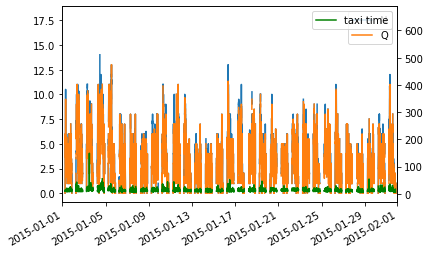

In [229]:
fig,ax = plt.subplots()
plot_n_q = N_Q_df[['flight_datetime','N', 'Q']].set_index('flight_datetime').resample('5min').mean()
ax.plot(plot_n_q['N'], label='N')
ax.plot(plot_n_q['Q'], label = 'Q')
plt.legend()
ax2 = ax.twinx()
plt_taxi = merged_df[['flight_datetime', 'taxi_out']].set_index('flight_datetime').resample('5min').mean()
ax2.plot(plt_taxi, label='taxi time', color='green')
plt.legend()
plt.xlim(np.datetime64('2015-01-01'), np.datetime64('2015-02-01'))
fig.autofmt_xdate()
plt.show()


In [230]:
from fbprophet import Prophet
#del(m)
m = Prophet(weekly_seasonality=True, daily_seasonality=True, seasonality_mode='multiplicative')
m.add_country_holidays(country_name='UK')
df_proph = merged_df[['flight_datetime', 'taxi_out']]
df_proph.columns = ['ds', 'y']
df_proph = df_proph.set_index('ds').resample('5min').mean()
df_proph.reset_index(inplace=True)
m.fit(df_proph)

In [216]:
m_n = Prophet(weekly_seasonality=True, daily_seasonality=True, seasonality_mode='multiplicative')
m_n.add_country_holidays(country_name='UK')
df_proph_n = merged_df[['flight_datetime', 'N']]
df_proph_n.columns = ['ds', 'y']
df_proph_n = df_proph_n.set_index('ds').resample('5min').mean()
df_proph_n.reset_index(inplace=True)
m_n.fit(df_proph)

In [217]:
m_q = Prophet(weekly_seasonality=True, daily_seasonality=True, seasonality_mode='multiplicative')
m_q.add_country_holidays(country_name='UK')
df_proph_q = merged_df[['flight_datetime', 'Q']]
df_proph_q.columns = ['ds', 'y']
df_proph_q = df_proph_q.set_index('ds').resample('5min').mean()
df_proph_q.reset_index(inplace=True)
m_q.fit(df_proph)

C:\ProgramData\Anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\ProgramData\Anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\ProgramData\Anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\ProgramData\Anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



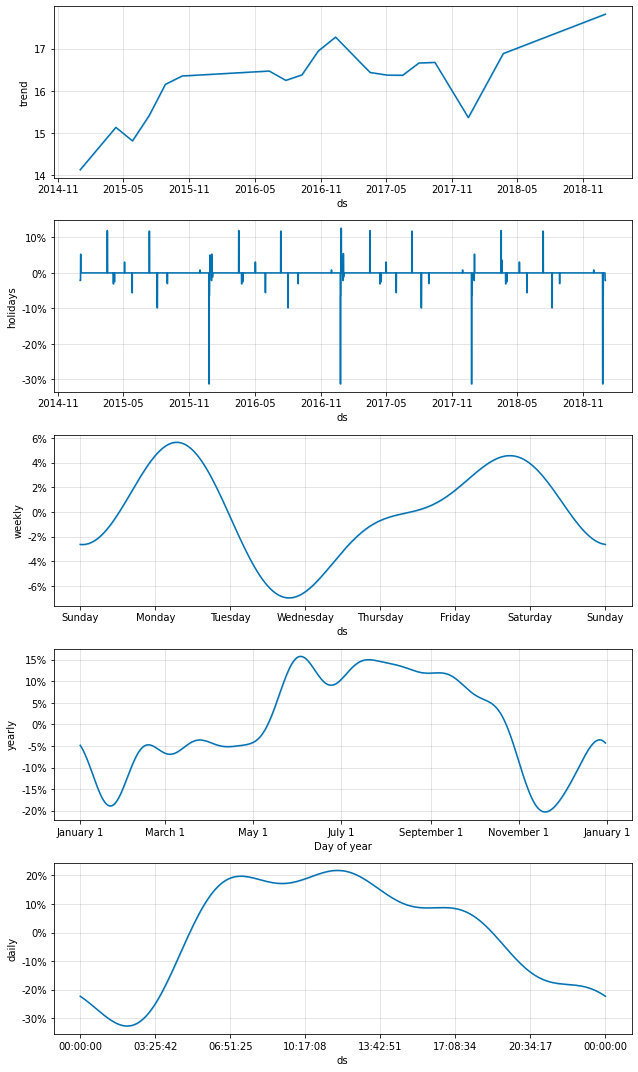

In [218]:
fig = m_n.plot_components(forecast)

<Figure size 1440x720 with 0 Axes>

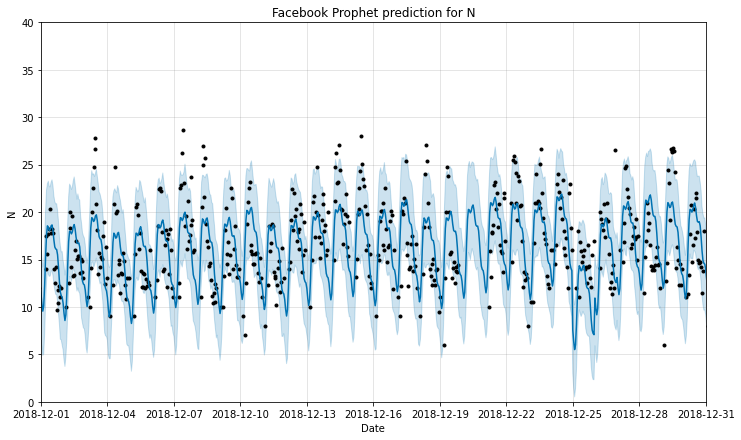

In [277]:
plt.figure(figsize=(20,10))
fig1 = m_n.plot(forecast)
plt.xlim(np.datetime64('2018-12-01'),np.datetime64('2018-12-31'))
plt.xlabel('Date')
plt.ylabel('N')
plt.title('Facebook Prophet prediction for N')
plt.ylim(0,40)
plt.show()

In [231]:
merged_df = merged_df.dropna()
merged_df['rounded_hour'] = merged_df['flight_datetime'].dt.round('H')
merged_df['rounded_5m'] = merged_df['flight_datetime'].dt.round('5min')
fb_prophet_est = m.history[['ds', 'y']]
fb_prophet_est.columns = ['rounded_5m', 'Taxi_prophet']
merged_df = merged_df.merge(fb_prophet_est)
fb_prophet_est = m_n.history[['ds', 'y']]
fb_prophet_est.columns = ['rounded_5m', 'N_prophet']
merged_df = merged_df.merge(fb_prophet_est)
fb_prophet_est = m_q.history[['ds', 'y']]
fb_prophet_est.columns = ['rounded_5m', 'Q_prophet']
merged_df = merged_df.merge(fb_prophet_est)

### Remove outliers

In [232]:
merged_df = merged_df[merged_df['taxi_out']<500]
merged_df['delay'] = (abs(merged_df['flight_datetime'] - merged_df['AOBT'])).astype('int64')/(6*10**10)

In [233]:
merged_df['taxi_out_mov_avg'] = merged_df.set_index('flight_datetime')['taxi_out'].rolling('60D', min_periods=1).mean().values

In [234]:
test = merged_df.groupby(['stand', 'runway']).median()[['distance', 'taxi_out']]
test['vel'] = test['distance']/test['taxi_out']
merged_df = merged_df.merge(test['vel'], left_on = ['stand', 'runway'], right_on=['stand', 'runway'])

### Isolating the target variable

In [235]:
y = merged_df.pop('taxi_out')

In [236]:
merged_df

,flight_datetime,aircraft_model,AOBT,ATOT,stand,runway,time_hourly,summary,temperature,dewPoint,...,N_rw,Q_rw,rounded_hour,rounded_5m,Taxi_prophet,N_prophet,Q_prophet,delay,taxi_out_mov_avg,vel
0,2015-01-01 06:00:00,B737-800 WINGLETS,2015-01-01 05:56:00,2015-01-01 06:05:00,STAND_62,RUNWAY_4,2015-01-01 06:00:00,Cloudy,44.65,42.80,...,0,0,2015-01-01 06:00:00,2015-01-01 06:00:00,9.000000,11.000000,11.000000,4.0,9.000000,63.888889
1,2015-01-04 08:00:00,B737-800 WINGLETS,2015-01-04 08:26:00,2015-01-04 08:41:00,STAND_62,RUNWAY_4,2015-01-04 08:00:00,Foggy,35.65,33.78,...,3,2,2015-01-04 08:00:00,2015-01-04 08:00:00,16.000000,16.166667,16.166667,26.0,14.510490,63.888889
2,2015-01-20 10:00:00,A321-100/200,2015-01-20 09:59:00,2015-01-20 10:14:00,STAND_62,RUNWAY_4,2015-01-20 10:00:00,Clear,26.68,26.62,...,0,0,2015-01-20 10:00:00,2015-01-20 10:00:00,14.500000,15.066667,15.066667,1.0,14.709302,63.888889
3,2015-01-25 16:00:00,A319,2015-01-25 16:08:00,2015-01-25 16:22:00,STAND_62,RUNWAY_4,2015-01-25 16:00:00,Cloudy,46.46,37.40,...,2,2,2015-01-25 16:00:00,2015-01-25 16:00:00,13.250000,13.000000,13.000000,8.0,14.723819,63.888889
4,2015-02-04 08:00:00,A319,2015-02-04 08:06:00,2015-02-04 08:21:00,STAND_62,RUNWAY_4,2015-02-04 08:00:00,Cloudy,33.84,32.02,...,2,2,2015-02-04 08:00:00,2015-02-04 08:00:00,20.500000,16.277778,16.277778,6.0,14.415038,63.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64984,2018-11-21 07:00:00,A319,2018-11-21 06:59:00,2018-11-21 07:10:00,STAND_10,RUNWAY_2,2018-11-21 07:00:00,Clear,35.31,33.78,...,0,0,2018-11-21 07:00:00,2018-11-21 07:00:00,12.250000,17.680000,17.680000,1.0,19.290358,136.052632
64985,2018-11-26 17:00:00,A320-100/200,2018-11-26 17:33:00,2018-11-26 17:52:00,STAND_10,RUNWAY_2,2018-11-26 17:00:00,Clear,44.65,41.00,...,1,1,2018-11-26 17:00:00,2018-11-26 17:00:00,17.333333,19.550000,19.550000,33.0,19.062664,136.052632
64986,2018-12-07 09:00:00,A330-300,2018-12-07 09:40:00,2018-12-07 10:09:00,STAND_10,RUNWAY_2,2018-12-07 09:00:00,Clear,53.65,51.79,...,4,4,2018-12-07 09:00:00,2018-12-07 09:00:00,25.333333,26.269231,26.269231,40.0,18.404297,136.052632
64987,2018-12-07 12:00:00,A319,2018-12-07 12:14:00,2018-12-07 12:35:00,STAND_10,RUNWAY_2,2018-12-07 12:00:00,Clear,50.05,48.20,...,2,1,2018-12-07 12:00:00,2018-12-07 12:00:00,19.750000,18.521739,18.521739,14.0,18.413349,136.052632


In [237]:
X = merged_df

In [238]:
X['flight_day']=X['flight_datetime'].dt.day_name()

In [239]:
X['flight_month']=X['flight_datetime'].dt.month_name()

In [240]:
val = (X['flight_datetime'].dt.hour % 24 + 4) // 4
val.replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)

In [241]:
X['day_moment']=val

In [242]:
X = X.drop(['flight_datetime','aircraft_model','AOBT','ATOT','stand','index','time_hourly','manufacturer','full_aircraft_model'], axis=1)

In [243]:
X.columns

Index(['runway', 'summary', 'temperature', 'dewPoint', 'humidity', 'windSpeed',
       'windGust', 'windBearing', 'cloudCover', 'uvIndex', 'visibility',
       'Lat_runway', 'Lng_runway', 'Lat_stand', 'Lng_stand', 'engine class',
       'number_engines', 'approach_speed', 'wingtip_config', 'wingspan_feet',
       'length_feet', 'tail_height_feet', 'wheelbase_feet',
       'cockpit_to_main_gear_feet', 'main_gear_width', 'max_takeoff_weight',
       'max_ramp_taxi_weight', 'parking_area_square_feet',
       'number_gear_types_tandem', 'distance', 'N', 'Q', 'N_rw', 'Q_rw',
       'rounded_hour', 'rounded_5m', 'Taxi_prophet', 'N_prophet', 'Q_prophet',
       'delay', 'taxi_out_mov_avg', 'vel', 'flight_day', 'flight_month',
       'day_moment'],
      dtype='object')

In [244]:
X['number_engines'] = pd.to_numeric(X['number_engines'], downcast="float")
X['wingspan_feet'] = pd.to_numeric(X['wingspan_feet'], downcast="float")
X['length_feet'] = pd.to_numeric(X['length_feet'], downcast="float")
X['tail_height_feet'] = pd.to_numeric(X['tail_height_feet'], downcast="float")
X['wheelbase_feet'] = pd.to_numeric(X['wheelbase_feet'], downcast="float")
X['cockpit_to_main_gear_feet'] = pd.to_numeric(X['cockpit_to_main_gear_feet'], downcast="float")
X['main_gear_width'] = pd.to_numeric(X['main_gear_width'], downcast="float")
X['max_takeoff_weight'] = pd.to_numeric(X['max_takeoff_weight'], downcast="float")
X['max_ramp_taxi_weight'] = pd.to_numeric(X['max_ramp_taxi_weight'], downcast="float")
X['parking_area_square_feet'] = pd.to_numeric(X['parking_area_square_feet'], downcast="float")

In [245]:
X.select_dtypes('object').columns.tolist()

['runway',
 'summary',
 'engine class',
 'wingtip_config',
 'number_gear_types_tandem',
 'flight_day',
 'flight_month',
 'day_moment']

In [246]:
from sklearn.preprocessing import OneHotEncoder

# seleziona le features non numeriche
cat_column_names = X.select_dtypes('object').columns.tolist()
print(cat_column_names)
#cat_column_names.remove('Note')
#cat_column_names.remove('Years Manufactured')
#cat_column_names.remove('Wheelbase, ft')



# Fit dell'encoder sul train
ohe = OneHotEncoder(
    sparse=False,
    handle_unknown='ignore'  # mette tutti zero nel caso trovassimo classi sconosciute durante il "transform"
)
# converto in stringa, così anche eventuali nulli saranno categorie, poi faccio fit
ohe.fit(X[cat_column_names].astype(str))

# l'output di OneHotEncoder.transform sarà un numpy array, ma lo voglio ritrasformare in pandas dataframe
new_column_names = [
    f"{category} - {level}" for category, level_list in zip(cat_column_names, ohe.categories_)
    for level in level_list]

X_ohe = pd.DataFrame(
    ohe.transform(X[cat_column_names].astype(str)),
    index=X.index,
    columns=new_column_names)

# butto via le vecchie colonne categoriche e aggiungo le nuove
X = pd.concat([
    X.drop(cat_column_names, axis=1),
    X_ohe], axis=1)


['runway', 'summary', 'engine class', 'wingtip_config', 'number_gear_types_tandem', 'flight_day', 'flight_month', 'day_moment']


In [247]:
X.columns

Index(['temperature', 'dewPoint', 'humidity', 'windSpeed', 'windGust',
       'windBearing', 'cloudCover', 'uvIndex', 'visibility', 'Lat_runway',
       'Lng_runway', 'Lat_stand', 'Lng_stand', 'number_engines',
       'approach_speed', 'wingspan_feet', 'length_feet', 'tail_height_feet',
       'wheelbase_feet', 'cockpit_to_main_gear_feet', 'main_gear_width',
       'max_takeoff_weight', 'max_ramp_taxi_weight',
       'parking_area_square_feet', 'distance', 'N', 'Q', 'N_rw', 'Q_rw',
       'rounded_hour', 'rounded_5m', 'Taxi_prophet', 'N_prophet', 'Q_prophet',
       'delay', 'taxi_out_mov_avg', 'vel', 'runway - RUNWAY_1',
       'runway - RUNWAY_2', 'runway - RUNWAY_3', 'runway - RUNWAY_4',
       'summary - Clear', 'summary - Clouds and Wind', 'summary - Cloudy',
       'summary - Dangerously Windy', 'summary - Drizzle', 'summary - Foggy',
       'summary - Possible Drizzle', 'summary - Possible Light Rain',
       'summary - Rain', 'summary - Rain and Wind', 'engine class - Jet',
   

### Remove outliers

### Applying a scaling

In [248]:
X.select_dtypes('float').columns.tolist()

['temperature',
 'dewPoint',
 'humidity',
 'windSpeed',
 'windGust',
 'windBearing',
 'cloudCover',
 'uvIndex',
 'visibility',
 'Lat_runway',
 'Lng_runway',
 'Lat_stand',
 'Lng_stand',
 'approach_speed',
 'distance',
 'Taxi_prophet',
 'N_prophet',
 'Q_prophet',
 'delay',
 'taxi_out_mov_avg',
 'vel',
 'runway - RUNWAY_1',
 'runway - RUNWAY_2',
 'runway - RUNWAY_3',
 'runway - RUNWAY_4',
 'summary - Clear',
 'summary - Clouds and Wind',
 'summary - Cloudy',
 'summary - Dangerously Windy',
 'summary - Drizzle',
 'summary - Foggy',
 'summary - Possible Drizzle',
 'summary - Possible Light Rain',
 'summary - Rain',
 'summary - Rain and Wind',
 'engine class - Jet',
 'engine class - Turboprop',
 'wingtip_config - no winglets',
 'wingtip_config - winglets',
 'wingtip_config - wingtip fences',
 'number_gear_types_tandem - 1',
 'number_gear_types_tandem - 2',
 'number_gear_types_tandem - 3',
 'flight_day - Friday',
 'flight_day - Monday',
 'flight_day - Saturday',
 'flight_day - Sunday',
 'flig

In [249]:
#X = X.drop('index',axis=1)
#X = X.drop('taxi_out',axis=1)

In [250]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_cols = ['temperature','dewPoint','humidity','windSpeed','windGust','windBearing','cloudCover',
 'uvIndex','visibility','approach_speed','distance']
X[num_cols] = scaler.fit_transform(X[num_cols])
X_bkp = X.copy()

In [286]:
X = X_bkp.copy()
X = X.drop(['rounded_5m','Lat_runway','Lng_runway','Lat_stand','Lng_stand', 'vel', 'rounded_hour', 'Q','N_prophet', 'N_rw', 'Q_rw'], axis=1)
#X['N_Q'] = X['N']*X['Q']

In [287]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [288]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43542 entries, 25593 to 56422
Data columns (total 73 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   temperature                      43542 non-null  float64
 1   dewPoint                         43542 non-null  float64
 2   humidity                         43542 non-null  float64
 3   windSpeed                        43542 non-null  float64
 4   windGust                         43542 non-null  float64
 5   windBearing                      43542 non-null  float64
 6   cloudCover                       43542 non-null  float64
 7   uvIndex                          43542 non-null  float64
 8   visibility                       43542 non-null  float64
 9   number_engines                   43542 non-null  float32
 10  approach_speed                   43542 non-null  float64
 11  wingspan_feet                    43542 non-null  float32
 12  length_feet   

In [289]:
import numpy as np
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.547048459757129

In [290]:
for i in range(len(reg.coef_)):
    print (X.columns[i],reg.coef_[i])
display(np.sort(reg.coef_))

temperature 0.14119881870254644
dewPoint -0.06365433666829587
humidity 0.04349465675831736
windSpeed -0.004410831254207548
windGust 0.024885626112571196
windBearing 0.019989460463950004
cloudCover -0.008234891647909026
uvIndex 0.011196927438848814
visibility -0.01123419053291505
number_engines 2.5819332055697966
approach_speed 1.1303443240673292
wingspan_feet -0.2829823426141019
length_feet -0.29789007093845554
tail_height_feet 0.4361979953507904
wheelbase_feet 0.2270248626173347
cockpit_to_main_gear_feet -0.11091946224099467
main_gear_width 0.34154929328858136
max_takeoff_weight -0.001071622779178244
max_ramp_taxi_weight 0.0010349768353056787
parking_area_square_feet 0.0015277747196233982
distance 0.029425231622610952
N 0.26848318867100013
Taxi_prophet 0.9271113062069655
Q_prophet -0.022612540977862416
delay -0.0003893734395781223
taxi_out_mov_avg -0.03181844526927849
runway - RUNWAY_1 0.005994264956774508
runway - RUNWAY_2 -0.02987984434486435
runway - RUNWAY_3 -0.03962303227430354
r

array([-2.52569747e+00, -1.20962886e+00, -6.33873882e-01, -5.52872094e-01,
       -5.05011178e-01, -5.04043573e-01, -4.33562981e-01, -4.19111404e-01,
       -4.18792017e-01, -4.15455323e-01, -4.04122830e-01, -3.65469807e-01,
       -3.42515762e-01, -2.97890071e-01, -2.89693216e-01, -2.82982343e-01,
       -2.71123634e-01, -2.32019745e-01, -2.22648974e-01, -2.02993842e-01,
       -1.97659844e-01, -1.84826336e-01, -1.61698905e-01, -1.10919462e-01,
       -7.23012967e-02, -6.36543367e-02, -6.08957956e-02, -4.88944843e-02,
       -4.17601657e-02, -3.96230323e-02, -3.18184453e-02, -3.02755941e-02,
       -2.98798443e-02, -2.26125410e-02, -1.12341905e-02, -8.23489165e-03,
       -4.41083125e-03, -1.07162278e-03, -3.89373440e-04,  1.03497684e-03,
        1.52777472e-03,  5.99426496e-03,  1.11969274e-02,  1.99894605e-02,
        2.48856261e-02,  2.94252316e-02,  4.34946568e-02,  6.35086117e-02,
        6.57427672e-02,  6.95227076e-02,  8.40387788e-02,  1.13943326e-01,
        1.20177476e-01,  

In [291]:
predictions_gbm = pd.DataFrame(y_test)
# Predict
predictions_gbm['lower'] = reg.predict(X_test)-3
predictions_gbm['prediction'] = reg.predict(X_test)
predictions_gbm['upper'] = reg.predict(X_test)+3

predictions_gbm['in']= predictions_gbm['taxi_out'].between(predictions_gbm['lower'],predictions_gbm['upper'])

print("accuracy within 3 minutes error with gbm: ",round(sum(predictions_gbm['in'])/len(predictions_gbm)*100,2),"%")

accuracy within 3 minutes error with gbm:  66.05 %


In [292]:
predictions_gbm['lower'] = reg.predict(X_test)-5
predictions_gbm['prediction'] = reg.predict(X_test)
predictions_gbm['upper'] = reg.predict(X_test)+5

predictions_gbm['in']= predictions_gbm['taxi_out'].between(predictions_gbm['lower'],predictions_gbm['upper'])

print("accuracy within 5 minutes error with gbm: ",round(sum(predictions_gbm['in'])/len(predictions_gbm)*100,2),"%")

accuracy within 5 minutes error with gbm:  83.78 %


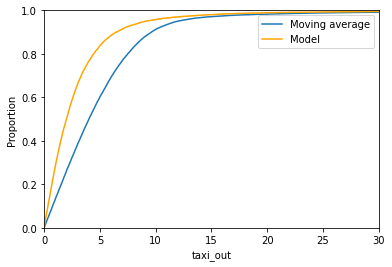

In [293]:
fig, ax = plt.subplots()
sns.ecdfplot(abs(merged_df['taxi_out_mov_avg'] - y), ax=ax, label='Moving average')
sns.ecdfplot(abs(reg.predict(X_test) - y_test), color='orange', ax=ax, label='Model')
plt.legend()
plt.xlim(0,30)
plt.show()

In [269]:
from sklearn.ensemble import GradientBoostingRegressor
xgb = GradientBoostingRegressor()
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

0.527375258993507

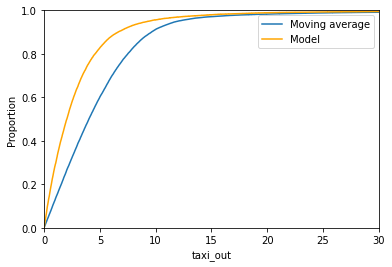

In [270]:
fig, ax = plt.subplots()
sns.ecdfplot(abs(merged_df['taxi_out_mov_avg'] - y), ax=ax, label='Moving average')
sns.ecdfplot(abs(xgb.predict(X_test) - y_test), color='orange', ax=ax, label='Model')
plt.legend()
plt.xlim(0,30)
plt.show()

In [ ]:
fig, ax = plt.subplots()
sns.ecdfplot(abs(merged_df['taxi_out_mov_avg'] - y), ax=ax, label='Moving average')
sns.ecdfplot(abs(xgb.predict(X_train) - y_train), color='orange', ax=ax, label='Model')
plt.legend()
plt.xlim(0,10)
plt.xlabel('Error between the actual taxing time and predicted in minutes')
plt.ylabel('Empirical cumulative distribution function')
plt.show()

In [ ]:
np.percentile(abs(merged_df['taxi_out_mov_avg'] - y), 95)

In [ ]:
np.percentile(abs(xgb.predict(X_train) - y_train), 95)

In [ ]:
from sklearn.linear_model import SGDRegressor
regr = SGDRegressor(max_iter=1000, tol=1e-3)
regr.fit(X_train, y_train)


In [ ]:
regr.score(X_test, y_test)

In [ ]:

from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

# Loading some example data

# Training classifiers
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg = ereg.fit(X_train, y_train)



In [ ]:
ereg.score(X_test, y_test)

In [279]:
predictions_gbm = pd.DataFrame(y_test)
# Predict
predictions_gbm['lower'] = xgb.predict(X_test)-3
predictions_gbm['prediction'] = xgb.predict(X_test)
predictions_gbm['upper'] = xgb.predict(X_test)+3

predictions_gbm['in']= predictions_gbm['taxi_out'].between(predictions_gbm['lower'],predictions_gbm['upper'])

print("accuracy within 3 minutes error with gbm: ",round(sum(predictions_gbm['in'])/len(predictions_gbm)*100,2),"%")

accuracy within 3 minutes error with gbm:  64.74 %


In [ ]:
predictions_gbm = pd.DataFrame(y_test)
# Predict
predictions_gbm['lower'] = ereg.predict(X_test)-5
predictions_gbm['prediction'] = ereg.predict(X_test)
predictions_gbm['upper'] = ereg.predict(X_test)+5

predictions_gbm['in']= predictions_gbm['taxi_out'].between(predictions_gbm['lower'],predictions_gbm['upper'])

print("accuracy within 5 minutes error with gbm: ",round(sum(predictions_gbm['in'])/len(predictions_gbm)*100,2),"%")

In [ ]:
fig, ax = plt.subplots()
sns.ecdfplot(abs(merged_df['taxi_out_mov_avg'] - y), ax=ax, label='Moving average')
sns.ecdfplot(abs(ereg.predict(X_test) - y_test), color='orange', ax=ax, label='Model')
plt.legend()
plt.xlim(0,30)
plt.show()

In [ ]:
np.percentile(abs(ereg.predict(X_test) - y_test), 95)

In [ ]:
np.percentile(abs(merged_df['taxi_out_mov_avg'] - y), 95)

In [ ]:
np.percentile(abs(xgb.predict(X_test) - y_test), 95)

In [ ]:
pd.read_excel('../../Resources/test_set_weather_data.xlsx')

In [ ]:
df_weather

In [ ]:
dataset_cleaning = importlib.import_module("utils.dataset_cleaning")
test_airp = dataset_cleaning.clean_airport('../../Resources/test_set_airport_data.xlsx', 'test')

In [ ]:
dataset_cleaning = importlib.import_module("utils.dataset_cleaning")


In [ ]:
test_airp.columns = df_airport.columns

In [ ]:
dataset_cleaning.clean_airport()

In [ ]:
df_weather

In [ ]:
predictions_gbm = pd.DataFrame(y_test)
# Predict
predictions_gbm['lower'] = X['taxi_out_mov_avg']-3
predictions_gbm['prediction'] = X['taxi_out_mov_avg']
predictions_gbm['upper'] = X['taxi_out_mov_avg']+3

predictions_gbm['in']= predictions_gbm['taxi_out'].between(predictions_gbm['lower'],predictions_gbm['upper'])

print("accuracy within 3 minutes error with gbm: ",round(sum(predictions_gbm['in'])/len(predictions_gbm)*100,2),"%")

In [ ]:
#X_test.predictions_gbm = pd.DataFrame(y_test)
# Predict
predictions_gbm['lower'] = X['taxi_out_mov_avg']-5
predictions_gbm['prediction'] = X['taxi_out_mov_avg']
predictions_gbm['upper'] = X['taxi_out_mov_avg']+5

predictions_gbm['in']= predictions_gbm['taxi_out'].between(predictions_gbm['lower'],predictions_gbm['upper'])

print("accuracy within 5 minutes error with gbm: ",round(sum(predictions_gbm['in'])/len(predictions_gbm)*100,2),"%")

In [ ]:
predictions_gbm['lower'] = reg.predict(X_test)-3
predictions_gbm['prediction'] = reg.predict(X_test)
predictions_gbm['upper'] = reg.predict(X_test)+3

predictions_gbm['in']= predictions_gbm['taxi_out'].between(predictions_gbm['lower'],predictions_gbm['upper'])

print("accuracy within 3 minutes error with gbm: ",round(sum(predictions_gbm['in'])/len(predictions_gbm)*100,2),"%")

In [ ]:
predictions_gbm['lower'] = reg.predict(X_test)-5
predictions_gbm['prediction'] = reg.predict(X_test)
predictions_gbm['upper'] = reg.predict(X_test)+5

predictions_gbm['in']= predictions_gbm['taxi_out'].between(predictions_gbm['lower'],predictions_gbm['upper'])

print("accuracy within 5 minutes error with gbm: ",round(sum(predictions_gbm['in'])/len(predictions_gbm)*100,2),"%")

In [ ]:
import pickle

In [ ]:
pickle.save()